In [1]:
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [132]:
cases_hist = pd.read_csv('covid_cases.csv', index_col=0)
hosp_hist = pd.read_csv('covid_hosp.csv', index_col=0)
deaths_hist = pd.read_csv('covid_deaths.csv', index_col=0)

cases_hist.name = "positive cases"
hosp_hist.name = "hospitalizations"
deaths_hist.name = "deaths"

cases_hist

,Category,Variable,2020-03-26,2020-03-27,2020-03-28
0,NaN,Total,23112,26697,30765
1,NaN,Median Age (Range),47,47,48
2,Age Group,0 to 17,495,543,591
3,Age Group,18 to 44,10145,11617,13213
4,Age Group,45 to 64,7869,9158,10596
5,Age Group,65 to 74,2627,3034,3571
6,Age Group,75 and over,1935,2286,2724
7,Age 50 and over,Yes,10452,12209,14279
8,Age 50 and over,No,12619,14429,16416
9,Sex,Female,10124,11792,13592


In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
boroughs_wgs84 = gpd.read_file(url)
boroughs = boroughs_wgs84.to_crs({'init': 'epsg:2263'})

In [4]:
def max_boro_num(df):
    only_boros = df.loc[df['Category'] == 'Borough']
    only_nums = only_boros.select_dtypes(include=[np.number])
    return only_nums.max().max()

def round_up(num, p_val):
    return int(math.ceil(num / p_val)) * p_val

In [127]:
def add_geom(df, geom):
    if df.name == "deaths":
        geom_df = df.loc[(df['Category'] == 'Borough') & (df['Underlying Conditions'] == 'Total')]
        geom_df = geom_df.drop(columns='Underlying Conditions')
    else:
        geom_df = df.loc[df['Category'] == 'Borough']
    geom_df = geom_df.drop(columns='Category')
    geom = geom.rename(columns={'boro_name': 'Borough'})
    geom_df = geom.join(geom_df.set_index('Variable'), on='Borough')
    return geom_df

In [173]:
def subtable(df, category):
    if df.name == "deaths":
        sub_df = df.loc[(df['Category'] == category) & (df['Underlying Conditions'] == 'Total')]
        sub_df = sub_df.drop(columns='Underlying Conditions')
    else:
        sub_df = df.loc[df['Category'] == category]
    sub_df = sub_df.drop(columns='Category')
    sub_df = sub_df.rename(columns={'Variable': 'Date'})
    sub_df = pd.DataFrame(sub_df).set_index('Date')
    sub_df = sub_df.transpose()
    sub_df.name = category
    return sub_df

In [128]:
cases_geo = add_geom(cases_hist, boroughs)
hosp_geo = add_geom(hosp_hist, boroughs)
deaths_geo = add_geom(deaths_hist, boroughs)

cases_geo

,boro_code,Borough,shape_area,shape_leng,geometry,2020-03-26,2020-03-27,2020-03-28
0,2,Bronx,1186612478.27,462958.187578,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",4243,4880,5752
1,5,Staten Island,1623757282.78,325956.009,"MULTIPOLYGON (((970217.022 145643.332, 970227....",1330,1534,1781
2,3,Brooklyn,1937593022.64,738745.842115,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",6095,7091,8129
3,4,Queens,3045878293.21,904188.424488,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",7362,8529,9831
4,1,Manhattan,636602658.887,361212.476098,"MULTIPOLYGON (((981219.056 188655.316, 980940....",4046,4627,5237


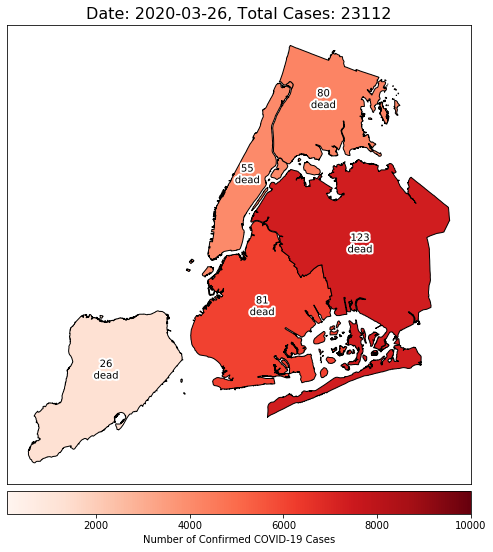

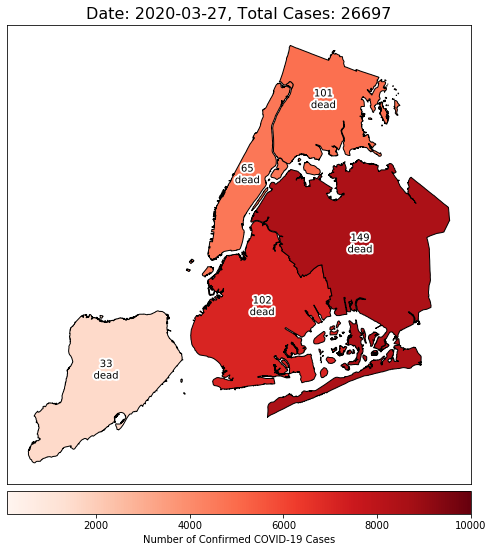

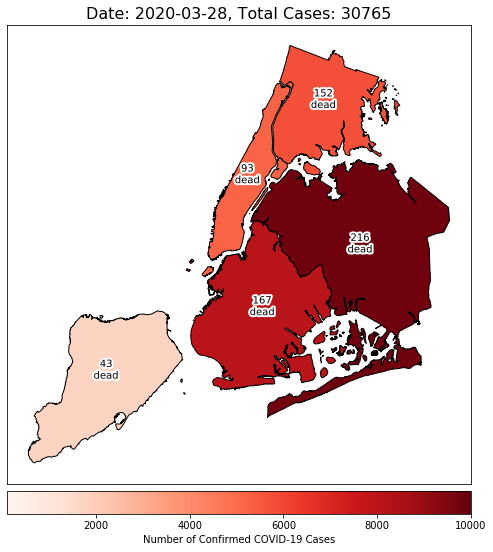

In [129]:
vmax = round_up(max_boro_num(cases_hist), 1000)
for date in cases_geo.columns[5:]:
    fig, ax = plt.subplots(figsize=(9, 9))
    total = cases_hist.loc[cases_hist['Variable'] == 'Total', date].values[0]
    title = 'Date: ' + str(date) + ', Total Cases: ' + str(total)
    plt.title(title, size='16')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    cs_fig = cases_geo.plot(ax=ax, column=date, cmap='Reds', 
                            edgecolor='black', legend=True, 
                            cax = cax, vmin=100, vmax=vmax,
                            legend_kwds={'label': 'Number of Confirmed COVID-19 Cases', 
                                         'orientation': 'horizontal'})
    ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)
    deaths_geo.apply(lambda x: cs_fig.annotate(s='{:.0f}\ndead'.format(x[date]),
                                               xy=x.geometry.centroid.coords[0],
                                               ha='center', color='black',
                                               path_effects=[pe.withStroke(linewidth=4,
                                                                           foreground='white')]),
                    axis=1)

plt.show()

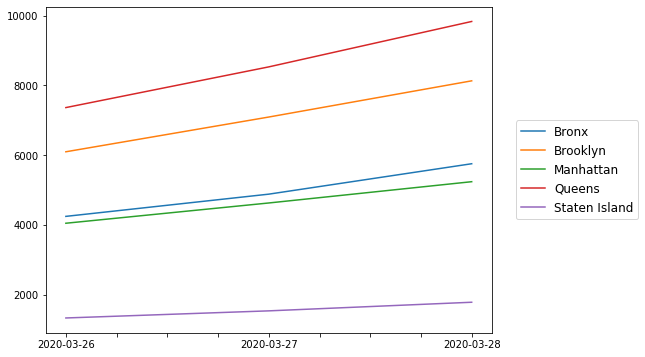

In [179]:
boro_df = subtable(cases_hist, 'Borough')

boro_df.plot.line(figsize=(8, 6))
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', 
           prop={'size': 12})

plt.show()

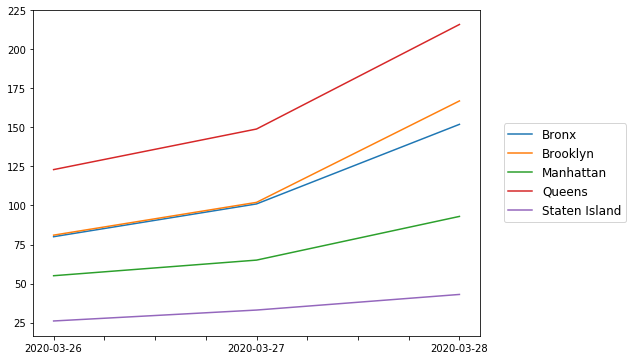

In [180]:
boro_df = subtable(deaths_hist, 'Borough')

boro_df.plot.line(figsize=(8, 6))
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', 
           prop={'size': 12})

plt.show()

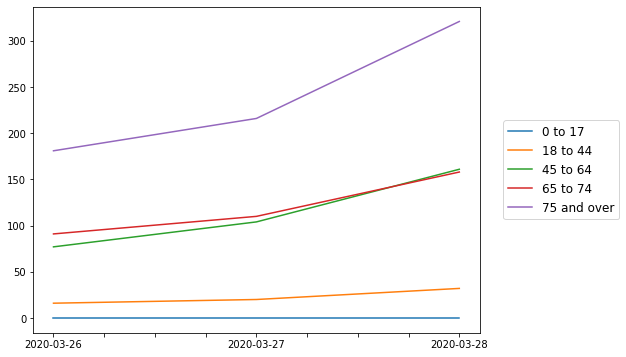

In [181]:
age_df = subtable(deaths_hist, 'Age Group')

age_df.plot.line(figsize=(8, 6))
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', 
           prop={'size': 12})

plt.show()